# Conformal Prediction in GNNs

## About

Graph Neural Networks (GNNs) are powerful machine learning algorithms
over graph-structured data. These models have seen success across several domains from
Antibiotic Discovery to Polypharmacy to Physical Simulation.
However, GNNs lack rigorous uncertainty estimates, limiting their deployment in high-stakes settings.

We will implement Huang et al's *Uncertainty Quantification over Conformalized GNNs* 
submitted to NeurIPS 2023. The paper demonstrates, both theoretically and empirically, 
the validity of Conformal Prediction in the context of GNNs. Moreover, the paper introduces CF-GNN, a 
topology-aware  correction model that notably tightens the confidence interval while maintaining accuracy. 
We propose  implementing conformalized GNNs in the experimental version of the [PyG Library](https://pyg.org/) as a general-purpose 
learning algorithm for node, edge, and graph classification problems. This will address the need 
for rigorous uncertainty estimates in prediction tasks.

This notebook introduce a proof-of-concept for how `Conformal` may exist within the broader PyG ecosystem.

## Background

Conformal Prediction is a modern framework in Statistical Learning Theory that aims to generate desirable prediction sets with guranteed coverage. Concretely, given features $X$ and labels $Y$ and miscoverage rate $\alpha$, our task is to produce a prediction band $\mathcal{C}$ for unseen observations $(X_{\text{test}}, Y_{\text{test}})$ sampled from the same distribution as the training examples.
$$
    1 - \alpha \leq P(Y_{\text{test}} \in C(X_{\text{test}})) \leq 1 - \alpha + \frac{1}{n + 1}
$$
In practice, any Conformal Prediction algorithm requires the following steps:
1. Identify a heuristic notion of uncertainty using the pre-trained model.
2. Define the score function $s(x, y) \in \mathbb{R}$ using this heuristic.
3. Compute $\hat{q}$ as $\left\lceil (n+1)(1 - \alpha) \right\rceil$ over the scores
4. Use this quantile to form the prediction set $C(X_{\text{test}}) = \{ y : s(X_{\text{test}}, y) \leq \hat{q} \}$

In principle, *any* score function may be used with coverage gurantee.
Still, by taking reasonable choices (e.g., steps 1 and 2) we can improve the quality of the prediction sets.
For instance, in classification tasks, one may treat the softmax over classes as the probabilities of being assigned that class.
A reasonable score function is $1 - \mathbb{P}(Y = y \mid X = x)$ which tells us how uncertain we are.

## Setup

In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import torch
import networkx as nx
from torch_geometric import utils
from torch_geometric.nn import GCNConv

## Dataset Walkthrough

The Karate Club dataset, collected by Wayne Zachary in the 1970s, captures the social interactions among 34 members of a university karate club. Each node in the network represents a club member. Each undirected edge denotes a friendship between two members. This dataset exhibits a natural community structure in alignment with a real-world conflict between an instructor and administrator. The Karate Club network is a popular benchmark for testing algorithms in community detection.

In [3]:
from torch_geometric.datasets import KarateClub

In [4]:
# Load Karate Club Dataset
dataset = KarateClub()
data = dataset[0]
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

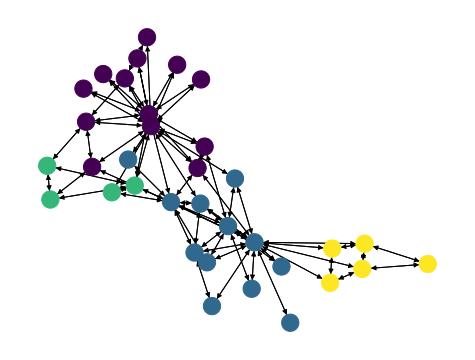

In [5]:
# Inspect Graph
g = utils.to_networkx(data)
nx.draw(g, node_color=data.y)

## Classification Example

The Karate Club graph includes ground-truth labels for node classification.

We will proceed with *Adaptive Prediction Sets* (APS) in order to generate prediction sets for the classification problem.
The basic idea is to define the following score function where $\pi$ is the permutation that ranks the classes from most to least likely.
$$
    s(x, y) = \sum_{j = 1}^{k} \hat{f}(x)_{\pi_j(x)} \quad \text{where} \quad y = \pi_k(x).
$$
Intuitively, we want to include top-rank classes until the cumlative sum of their probabilities meets the desired coverage.
By doing this from most likely to least likely, we ensure the prediction set is minimal.
For this reason, the prediction sets are feature adaptive.
$$
    \mathcal{C}(x) = \{ \pi_1(x), \ldots, \pi_k(x) \}, \text{ where } k = \sup \left\{ k' : \sum_{j=1}^{k'} \hat{f}(X_{\text{test}})\pi_j(x) <  \hat{q} \right\} + 1,
$$

In [6]:
from confgnn.models import ConformalPredictor
from confgnn.tools import plot_regression, plot_classification

In [7]:
# Initialize Classifier Instance
conf = ConformalPredictor(
    in_channels=dataset.num_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    task='classification'
)

In [8]:
# Train and calibrate
conf.fit(data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
# Make predictions
pred, pred_sets = conf.predict(data)

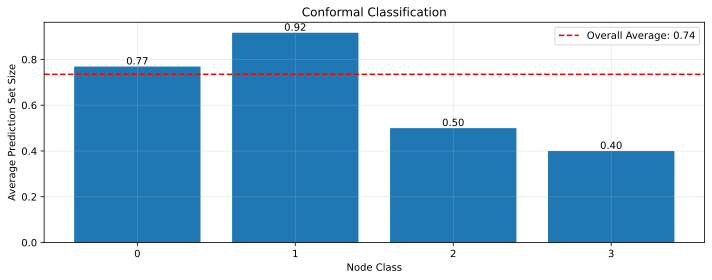

In [10]:
# Inspect Inefficiency
plot_classification(pred_sets, data.y, dataset.num_classes, 'Conformal Classification')

## Regression Example

The Karate Club graph does not include labels for node regression. Instead, we will use a random feature.

We will proceed with *Conformal Quantile Regression* (CQR) in order to generate prediction sets (intervals) for the regression problem.
We introduce learned functions $\hat{t}_{\alpha/2}(x)$ and $\hat{t}_{1 - \alpha/2}(x)$ that estimate the upper and lower bound. 
They are trained on the following objective known as the Quantile (Pinball) Loss:
$$
    L_{\tau}(\hat{t}, y) = 
    \begin{cases} 
    (y - \hat{t}) \tau & \text{if } y > \hat{t}, \\
    (\hat{t} - y)(1 - \tau) & \text{if } y \leq \hat{t}.
    \end{cases}
$$
With these functions on hand, we construct the score function.
$$
    s(x, y) = \max \left( \hat{t}_{\alpha/2}(x) - y, \; y - \hat{t}_{1 - \alpha/2}(x) \right)
$$
Intuitively, we want to center our prediction sets on the known label s.t. and move up and down s.t. the desired coverage is met. 
$$
    \mathcal{C}(x) = \left[ \hat{t}_{\alpha/2}(x) - \hat{q}, \; \hat{t}_{1 - \alpha/2}(x) + \hat{q} \right].
$$

In [11]:
# Synthetic Target
data.y = torch.randn(data.num_nodes, 1)

In [12]:
# Initialize Regressor Instance
conf = ConformalPredictor(
    in_channels=dataset.num_features,
    hidden_channels=16,
    out_channels=1,
    task='regression'
)

In [13]:
# Train and calibrate
conf.fit(data)

In [14]:
# Make predictions
pred, lower, upper = conf.predict(data)

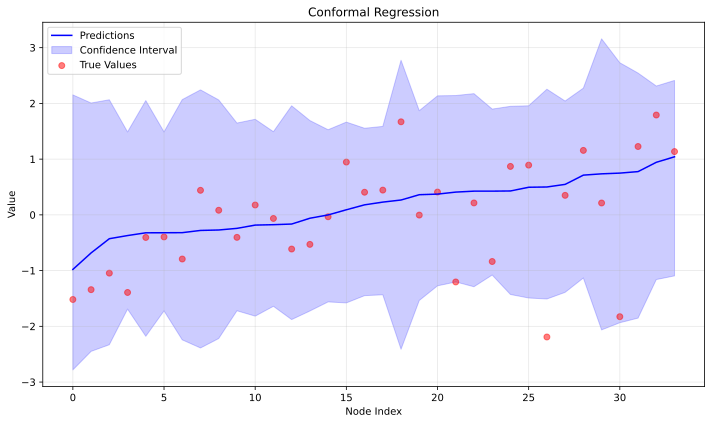

In [15]:
# Inspect Prediction Sets
plot_regression(pred, lower, upper, data.y, 'Conformal Regression')